Code for comparions and evaluation of data

In [29]:
import os
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from matplotlib.colors import Normalize 

In [30]:
# Get the relevant blocks at the innner mierendorff Insel
# Load Block level data 
block_data = gpd.read_file(r'auxillary\00_block_shape.shp')
outer_mierendorff = ["019609", "019017", "019808", "019901", "020902", "019708"]
block_data['blknr'] = block_data["blknr"].astype(str)
block_data = block_data[~block_data["blknr"].isin(outer_mierendorff)]

In [31]:
import os
import geopandas as gpd
import pandas as pd

data_dict = {
    "project": [],
    "blknr": [],
    "QH_sys_MWhyr_2020": [],
    "E_sys_MWhyr_2020": [],
    "QH_sys_MWhyr_2021": [],
    "E_sys_MWhyr_2021": [],
    "QH_sys_MWhyr_2022": [],
    "E_sys_MWhyr_2022": []
}

# Assuming block_data is defined somewhere above this snippet
buildings_with_block = None  # Initialize outside the loop

for project in os.listdir(r'CEA_model337'):
    for year in os.listdir(os.path.join(r'CEA_model337', project)):
        if year == "2020":
            CEA_shape_path = os.path.join('CEA_model337', project, year, 'inputs', 'building-geometry', 'zone.shp')
            CEA_shape = gpd.read_file(CEA_shape_path)
            CEA_shape = CEA_shape.to_crs(block_data.crs)
            buildings_with_block = gpd.sjoin(CEA_shape, block_data, how="inner", predicate='intersects')

    if buildings_with_block is not None:
        block_numbers = list(block_data["blknr"])
        for block_number in block_numbers:
            buildings_in_block = buildings_with_block[buildings_with_block['blknr'] == block_number]
            if buildings_in_block.empty:
                continue
            else:
                data_dict['blknr'].append(block_number)
                data_dict['project'].append(project)
                for year in [2020, 2021, 2022]:
                    path = os.path.join('CEA_model', 'DefaultModel', f'{year}_GER_Updated', 'outputs', 'data', 'demand', 'Total_demand.csv')
                    df = pd.read_csv(path)
                    building_names = buildings_in_block['Name'].tolist()
                    filtered_df = df[df['Name'].isin(building_names)]
                    
                    data_dict[f"QH_sys_MWhyr_{year}"].append(filtered_df["QH_sys_MWhyr"].sum())
                    data_dict[f"E_sys_MWhyr_{year}"].append(filtered_df["E_sys_MWhyr"].sum())

data_df = pd.DataFrame(data_dict)


In [23]:
# Load Measured Data for electricity
elec_data = pd.read_excel(r'auxillary\Elec_Berlin_2020_2022.xls')
gas_data = pd.read_excel(r'auxillary\Gas_Berlin_2020_2022.xls')
dh_data = pd.read_excel(r'auxillary\DH_Berlin_2020_2022.xls')
block_data["blknr"] = block_data["blknr"].astype(int)   

dh_data = dh_data.rename(columns={"Blocknummer": "blknr"})
dh_data_shapes = block_data.merge(dh_data, on='blknr', how='left')
elec_data = elec_data.rename(columns={"Blocknummer": "blknr"})  
elec_data_shapes = block_data.merge(elec_data, on='blknr', how='left')
gas_data = gas_data.rename(columns={"Blocknummer": "blknr"})
gas_data_shapes = block_data.merge(gas_data, on='blknr', how='left')

# Adjust types 
# Code from: https://github.com/TUB-DVG/TECDEM/blob/main/experiments/81_PlotBlock.ipynb 
elec_columns_to_check = [
        "Stromverbrauch 2022 [MWh]",
        "Stromverbrauch 2021 [MWh]",
        "Stromverbrauch 2020 [MWh]"
    ]

for column in elec_columns_to_check:
        elec_data_shapes[column] = pd.to_numeric(elec_data_shapes[column], errors='coerce')

elec_data_shapes["valid_entries"] = elec_data_shapes[elec_columns_to_check].apply(lambda x: (x > 0).sum(), axis=1)

gas_columns_to_check = [
        "Gasverbrauch 2022 [MWh]",
        "Gasverbrauch 2021 [MWh]",
        "Gasverbrauch 2020 [MWh]"
    ]

for column in gas_columns_to_check:
        gas_data_shapes[column] = pd.to_numeric(gas_data_shapes[column], errors='coerce')

gas_data_shapes["valid_entries"] = gas_data_shapes[gas_columns_to_check].apply(lambda x: (x > 0).sum(), axis=1)

dh_columns_to_check = [
        "Fernwärmeverbrauch 2022 [MWh]",
        "Fernwärmeverbrauch 2021 [MWh]",
        "Fernwärmeverbrauch 2020 [MWh]"
    ]

for column in dh_columns_to_check:
        dh_data_shapes[column] = pd.to_numeric(dh_data_shapes[column], errors='coerce')

dh_data_shapes["valid_entries"] = dh_data_shapes[dh_columns_to_check].apply(lambda x: (x > 0).sum(), axis=1)

In [32]:
data_df

,project,blknr,QH_sys_MWhyr_2020,E_sys_MWhyr_2020,QH_sys_MWhyr_2021,E_sys_MWhyr_2021,QH_sys_MWhyr_2022,E_sys_MWhyr_2022
0,Baseline,019033,107.590,119.781,107.764,119.782,107.877,119.783
1,Baseline,019692,319.201,484.892,319.217,484.892,319.193,484.892
2,Baseline,019742,1222.888,4131.979,1222.497,4131.969,1222.744,4131.974
3,Baseline,019759,0.000,0.000,0.000,0.000,0.000,0.000
4,Baseline,019760,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...
4291,Updated_DE_Database,020673,390.134,482.786,389.908,482.786,389.792,482.785
4292,Updated_DE_Database,020691,1335.622,1527.550,1334.694,1527.545,1335.888,1527.552
4293,Updated_DE_Database,021060,489.102,961.657,489.204,961.658,489.115,961.656
4294,Updated_DE_Database,021061,773.738,2047.310,773.514,2047.303,773.512,2047.304


In [25]:
import numpy as np
# Calculate MAE for each project and block
mae_dict = {}

# Function to replace '-' with np.nan and convert to float
def preprocess_data(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col].replace('-', np.nan), errors='coerce')
    return df

# Preprocess both project_df and dh_data before the loop
columns_to_preprocess_dh = ["Fernwärmeverbrauch 2022 [MWh]", "Fernwärmeverbrauch 2021 [MWh]", "Fernwärmeverbrauch 2020 [MWh]"]
# Preprocess data columns
columns_to_preprocess_project = ["QH_sys_MWhyr_2022", "QH_sys_MWhyr_2021", "QH_sys_MWhyr_2020", "E_sys_MWhyr_2022", "E_sys_MWhyr_2021", "E_sys_MWhyr_2020"]
columns_to_preprocess_dh = ["Fernwärmeverbrauch 2022 [MWh]", "Fernwärmeverbrauch 2021 [MWh]", "Fernwärmeverbrauch 2020 [MWh]"]
columns_to_preprocess_gas = ["Gasverbrauch 2022 [MWh]", "Gasverbrauch 2021 [MWh]", "Gasverbrauch 2020 [MWh]"]
columns_to_preprocess_elec = ["Stromverbrauch 2022 [MWh]", "Stromverbrauch 2021 [MWh]", "Stromverbrauch 2020 [MWh]"]

# Assuming data_df, dh_data, gas_data, and elec_data are already loaded
data_df = preprocess_data(data_df, columns_to_preprocess_project)
dh_data = preprocess_data(dh_data, columns_to_preprocess_dh)
gas_data = preprocess_data(gas_data, columns_to_preprocess_gas)
elec_data = preprocess_data(elec_data, columns_to_preprocess_elec)

# Calculate MAE for each project and block
mae_dict = {}

for project in data_df['project'].unique():
    print(project)
    project_df = data_df[data_df['project'] == project].drop_duplicates()
    for blk in project_df['blknr'].unique():
        try:
            project_blk_data = project_df[["QH_sys_MWhyr_2020", "QH_sys_MWhyr_2021", "QH_sys_MWhyr_2022"]][project_df['blknr'] == blk]
            dh_blk_data = dh_data[["Fernwärmeverbrauch 2022 [MWh]", "Fernwärmeverbrauch 2021 [MWh]", "Fernwärmeverbrauch 2020 [MWh]"]][dh_data['blknr'] == int(blk)]
            mae_heating = mean_absolute_error(project_blk_data, dh_blk_data)
            mae_dict[(project, blk, 'heating')] = mae_heating
        except ValueError as e:
            print("ValueError:", e, "for Block Number:", blk, "in Project:", project)
        except TypeError:
            print("TypeError")

        try:
            gas_blk_data = gas_data[["Gasverbrauch 2022 [MWh]", "Gasverbrauch 2021 [MWh]", "Gasverbrauch 2020 [MWh]"]][gas_data['blknr'] == int(blk)]
            mae_gas = mean_absolute_error(project_blk_data, gas_blk_data)
            mae_dict[(project, blk, 'gas')] = mae_gas
        except ValueError as e:
            print("ValueError:", e, "for Block Number:", blk, "in Project:", project)
        except TypeError:
            print("TypeError")

        try:
            project_blk_data = project_df[["E_sys_MWhyr_2020", "E_sys_MWhyr_2021", "E_sys_MWhyr_2022"]][project_df['blknr'] == blk]
            elec_blk_data = elec_data[["Stromverbrauch 2022 [MWh]", "Stromverbrauch 2021 [MWh]", "Stromverbrauch 2020 [MWh]"]][elec_data['blknr'] == int(blk)]
            mae_elec = mean_absolute_error(project_blk_data, elec_blk_data)
            mae_dict[(project, blk, 'electricity')] = mae_elec
        except ValueError as e:
            print("ValueError:", e, "for Block Number:", blk, "in Project:", project)
        except TypeError:
            print("TypeError")

# Create a DataFrame from the MAE dictionary
mae_df = pd.DataFrame(list(mae_dict.items()), columns=['project_blknr', 'mae'])
mae_df[['project', 'blknr', 'type']] = pd.DataFrame(mae_df['project_blknr'].tolist(), index=mae_df.index)
mae_df.drop(columns='project_blknr', inplace=True)
mae_df['blknr'] = mae_df['blknr'].astype(int)

Baseline
ValueError: Input contains NaN. for Block Number: 019033 in Project: Baseline
ValueError: Found input variables with inconsistent numbers of samples: [2, 1] for Block Number: 019692 in Project: Baseline
ValueError: Found input variables with inconsistent numbers of samples: [2, 1] for Block Number: 019692 in Project: Baseline
ValueError: Found input variables with inconsistent numbers of samples: [2, 1] for Block Number: 019692 in Project: Baseline
ValueError: Found input variables with inconsistent numbers of samples: [2, 1] for Block Number: 019742 in Project: Baseline
ValueError: Found input variables with inconsistent numbers of samples: [2, 1] for Block Number: 019742 in Project: Baseline
ValueError: Found input variables with inconsistent numbers of samples: [2, 1] for Block Number: 019742 in Project: Baseline
ValueError: Input contains NaN. for Block Number: 019759 in Project: Baseline
ValueError: Input contains NaN. for Block Number: 019759 in Project: Baseline
ValueEr

In [26]:
mae_df.sort_values(by='mae', ascending=False, inplace=True)
mae_df

,mae,project,blknr,type
253,3942.975333,DefaultModel,20051,gas
198,3942.975333,Benchmark_Normal_Refurbishment,20051,gas
33,3942.975333,Baseline,20051,gas
308,3942.975333,Updated_DE_Database,20051,gas
88,3942.975333,Benchmark,20051,gas
...,...,...,...,...
115,20.757667,Benchmark_Advanced_Refurbishment,20029,gas
5,20.757667,Baseline,20029,gas
280,20.757667,Updated_DE_Database,20029,gas
170,20.757667,Benchmark_Normal_Refurbishment,20029,gas


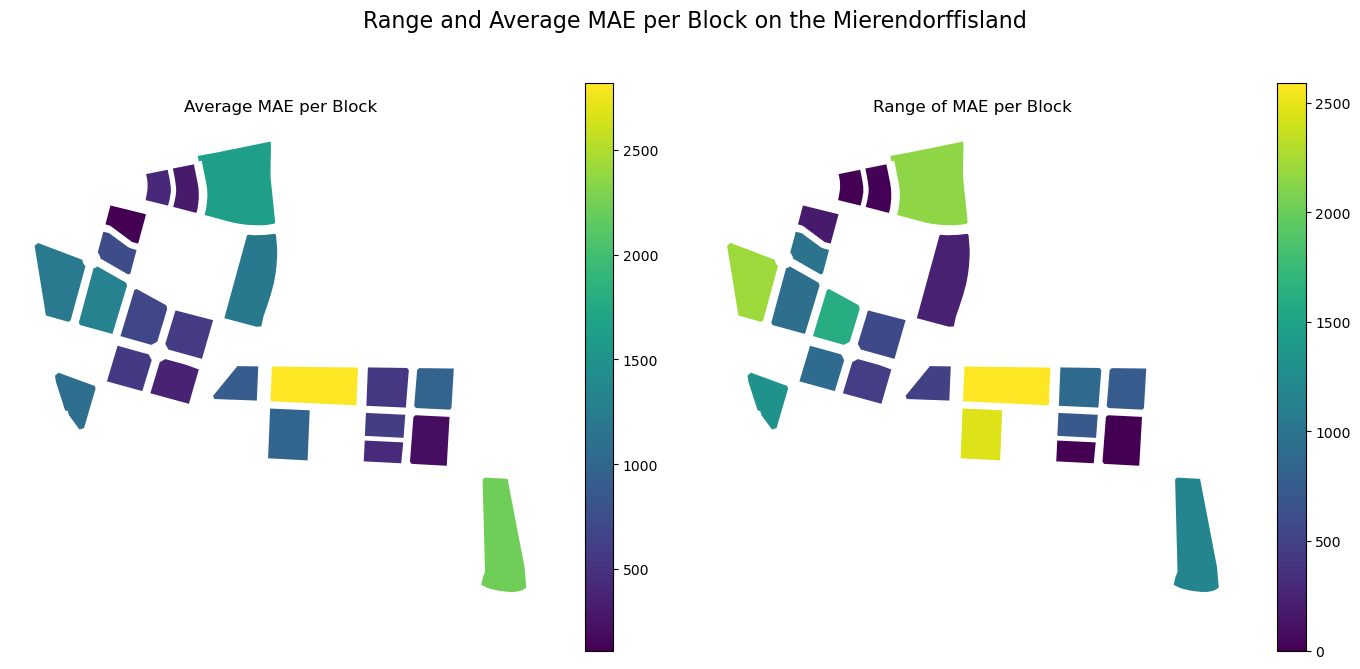

In [27]:

# Aggregate MAE values by block number to calculate range and average
agg_mae_df = mae_df.groupby('blknr')['mae'].agg(['mean', 'min', 'max']).reset_index()
agg_mae_df['range'] = agg_mae_df['max'] - agg_mae_df['min']
agg_mae_df.rename(columns={'mean': 'mae_mean'}, inplace=True)

# Merge with shape data
mae_gdf = block_data.merge(agg_mae_df, left_on='blknr', right_on='blknr', how='left')

# Plot the range and average MAE values
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Create the color map
cmap = plt.cm.viridis

# Define a normalization for the color mapping based on MAE mean
vmin_mean = mae_gdf['mae_mean'].min()
vmax_mean = mae_gdf['mae_mean'].max()
norm_mean = Normalize(vmin=vmin_mean, vmax=vmax_mean)

# Plotting average MAE
mae_gdf.plot(column='mae_mean', ax=axs[0], legend=True, cmap=cmap, norm=norm_mean)
axs[0].set_title('Average MAE per Block')
axs[0].axis('off')

# Define a normalization for the color mapping based on MAE range
vmin_range = mae_gdf['range'].min()
vmax_range = mae_gdf['range'].max()
norm_range = Normalize(vmin=vmin_range, vmax=vmax_range)

# Plotting range of MAE
mae_gdf.plot(column='range', ax=axs[1], legend=True, cmap=cmap, norm=norm_range)
axs[1].set_title('Range of MAE per Block')
axs[1].axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust space between plots

# Add a common title
fig.suptitle('Range and Average MAE per Block on the Mierendorffisland', fontsize=16)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make room for the common title

# Show plot
plt.show()

In [28]:
# Step 1: Aggregate MAE values by block number and type of mae to calculate range and average
agg_mae_df = mae_df.groupby(['blknr', 'type'])['mae'].agg(['mean', 'min', 'max']).reset_index()
agg_mae_df['range'] = agg_mae_df['max'] - agg_mae_df['min']
agg_mae_df.rename(columns={'mean': 'mae_mean'}, inplace=True)

# Step 2: Merge with shape data, considering 'type_of_mae'
# Assuming 'block_data' has a 'type_of_mae' column for matching
mae_gdf = block_data.merge(agg_mae_df, on=['blknr', 'type'], how='left')

# Plotting setup remains largely the same but needs to be done for each 'type_of_mae'
unique_types_of_mae = mae_gdf['type'].unique()

# Create subplots for each type of mae
fig, axs = plt.subplots(len(unique_types_of_mae), 2, figsize=(14, 7 * len(unique_types_of_mae)))

for index, mae_type in enumerate(unique_types_of_mae):
    current_mae_gdf = mae_gdf[mae_gdf['type'] == mae_type]

    # Define normalizations for the color mapping based on MAE mean and range
    vmin_mean = current_mae_gdf['mae_mean'].min()
    vmax_mean = current_mae_gdf['mae_mean'].max()
    norm_mean = Normalize(vmin=vmin_mean, vmax=vmax_mean)

    vmin_range = current_mae_gdf['range'].min()
    vmax_range = current_mae_gdf['range'].max()
    norm_range = Normalize(vmin=vmin_range, vmax=vmax_range)

    # Plotting average MAE
    current_mae_gdf.plot(column='mae_mean', ax=axs[index, 0], legend=True, cmap=cmap, norm=norm_mean)
    axs[index, 0].set_title(f'Average MAE per Block for {mae_type}')
    axs[index, 0].axis('off')

    # Plotting range of MAE
    current_mae_gdf.plot(column='range', ax=axs[index, 1], legend=True, cmap=cmap, norm=norm_range)
    axs[index, 1].set_title(f'Range of MAE per Block for {mae_type}')
    axs[index, 1].axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust space between plots

# Add a common title
fig.suptitle('Range and Average MAE per Block and Type on the Mierendorffisland', fontsize=16)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make room for the common title

# Show plot
plt.show()

KeyError: 'type'

In [ ]:
mae_df.columns

Index(['mae', 'project', 'blknr', 'type'], dtype='object')

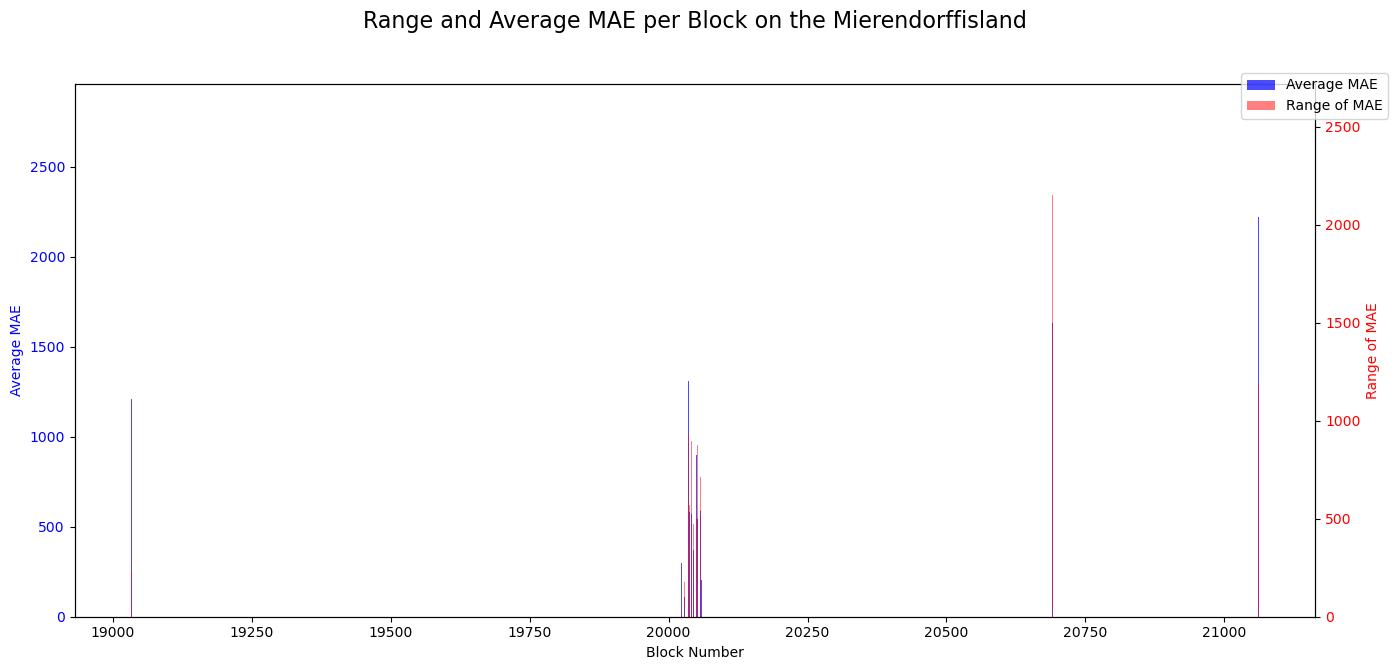

In [ ]:
# Plot the range and average MAE values using a bar chart
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar chart for average MAE
ax1.bar(agg_mae_df['blknr'], agg_mae_df['mae_mean'], color='b', alpha=0.7, label='Average MAE')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Average MAE', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the range
ax2 = ax1.twinx()
ax2.bar(agg_mae_df['blknr'], agg_mae_df['range'], color='r', alpha=0.5, label='Range of MAE')
ax2.set_ylabel('Range of MAE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title
fig.suptitle('Range and Average MAE per Block on the Mierendorffisland', fontsize=16)

# Show the legend
fig.legend(loc='upper right', bbox_to_anchor=(1,0.9))

# Adjust layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = mae_df

# Aggregating the data
agg_mae_df = df.groupby(['blknr', 'project']).mean().reset_index()

# Extracting unique block numbers and projects
blocks = agg_mae_df['blknr'].unique()
projects = agg_mae_df['project'].unique()

# Number of variables (blocks)
N = len(blocks)

# Angles for the axes
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialize the spider plot
fig, ax = plt.subplots(figsize=(14, 14), subplot_kw=dict(polar=True))

# Plotting data for each project
for project in projects:
    values = agg_mae_df[agg_mae_df['project'] == project]['mae'].tolist()
    values += values[:1]  # Closing the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=project)
    ax.fill(angles, values, alpha=0.25)

# Add labels for each axis
plt.xticks(angles[:-1], blocks)

# Add a title
plt.title('MAE per Block for Different Projects on the Mierendorffisland', size=16, color='black', y=1.1)

# Show the legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.1))

# Show the plot
plt.show()



TypeError: Could not convert gaselectricity to numeric

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the DataFrame from the uploaded CSV file
df = mae_df

# Aggregating the data by block number and project
agg_mae_df = df.groupby(['blknr', 'project']).mean().reset_index()

# Extracting unique block numbers and projects
blocks = agg_mae_df['blknr'].unique()
projects = agg_mae_df['project'].unique()

# Number of variables (blocks)
N = len(blocks)

# Angles for the axes
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialize the spider plot
fig, ax = plt.subplots(figsize=(14, 14), subplot_kw=dict(polar=True))

# Define a color map to ensure each project has a unique color
color_map = plt.cm.get_cmap('hsv', len(projects))

# Plotting data for each project
for i, project in enumerate(projects):
    values = agg_mae_df[agg_mae_df['project'] == project]['mae'].tolist()
    if len(values) < N:
        values += [0] * (N - len(values))  # Ensure all projects have the same length
    values += values[:1]  # Closing the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=project, color=color_map(i))
    ax.fill(angles, values, alpha=0.25, color=color_map(i))

# Add labels for each axis
plt.xticks(angles[:-1], blocks)

# Add a title
plt.title('MAE per Block for Different Projects on the Mierendorffisland', size=16, color='black', y=1.1)

# Show the legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.1))

# Show the plot
plt.show()


TypeError: Could not convert gaselectricity to numeric

In [ ]:
mae_df.to_csv(r'results/mae_df.csv', index=False)